In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy as sp
import gseapy as gp

import h5py
import warnings
import random
import math

from matplotlib import rcParams
from matplotlib import cm
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200)

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['savefig.transparent'] = True

In [3]:
adata = sc.read('./matrix_clustered.h5ad')
adata = adata[adata.obs['sort']=='CD45']

### Plot MS1 markers

In [4]:
lin='Mono'
adata = adata[adata.obs['lineage']==lin]
adata.X = adata.raw.X
sc.pp.highly_variable_genes(adata)
adata = adata[:,adata.var['highly_variable']]

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
1052


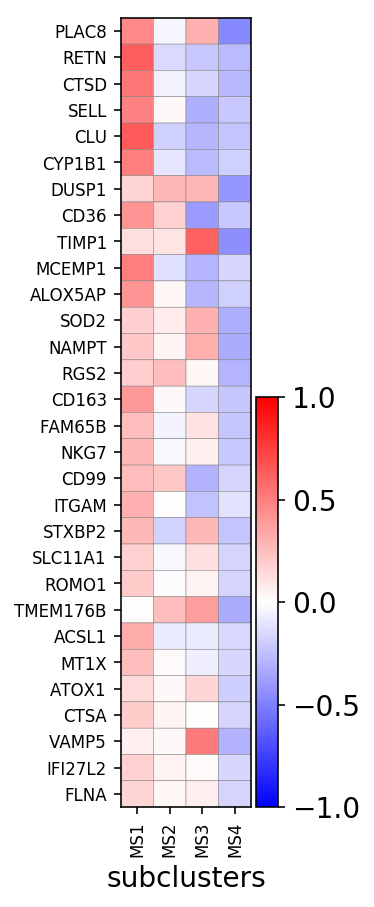

GridSpec(2, 3, height_ratios=[0, 6.0], width_ratios=[1.2, 0, 0.2])

In [5]:
sc.tl.rank_genes_groups(adata, 'subclusters', groups=['MS1'], reference='MS4', n_genes=2000, 
                        use_raw=False, method = 'wilcoxon')
i=0
pval_cutoff = sum(pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).iloc[:,i] < 1e-1)
pval_cutoff = pval_cutoff if pval_cutoff < 2000 else 2000
print(pval_cutoff)
diff_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:pval_cutoff,i]
sc.pp.scale(adata)
sc.pl.matrixplot(adata, var_names=diff_genes[:30], groupby='subclusters', use_raw=False, swap_axes=True,
                 vmin=-1, vmax=1, cmap='bwr')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
178


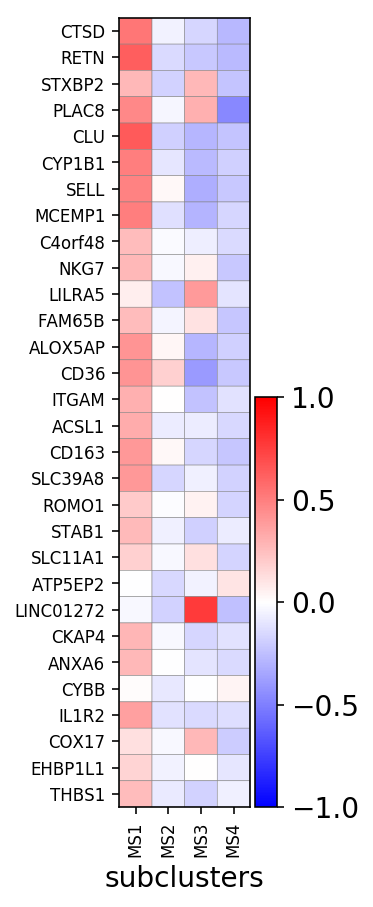

GridSpec(2, 3, height_ratios=[0, 6.0], width_ratios=[1.2, 0, 0.2])

In [6]:
sc.tl.rank_genes_groups(adata, 'subclusters', groups=['MS1'], reference='MS2', n_genes=2000, 
                        use_raw=False, method = 'wilcoxon')
i=0
pval_cutoff = sum(pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).iloc[:,i] < 1e-1)
pval_cutoff = pval_cutoff if pval_cutoff < 2000 else 2000
print(pval_cutoff)
diff_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:pval_cutoff,i]
sc.pp.scale(adata)
sc.pl.matrixplot(adata, var_names=diff_genes[:30], groupby='subclusters', use_raw=False, swap_axes=True,
                 vmin=-1, vmax=1, cmap='bwr')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:38)
506


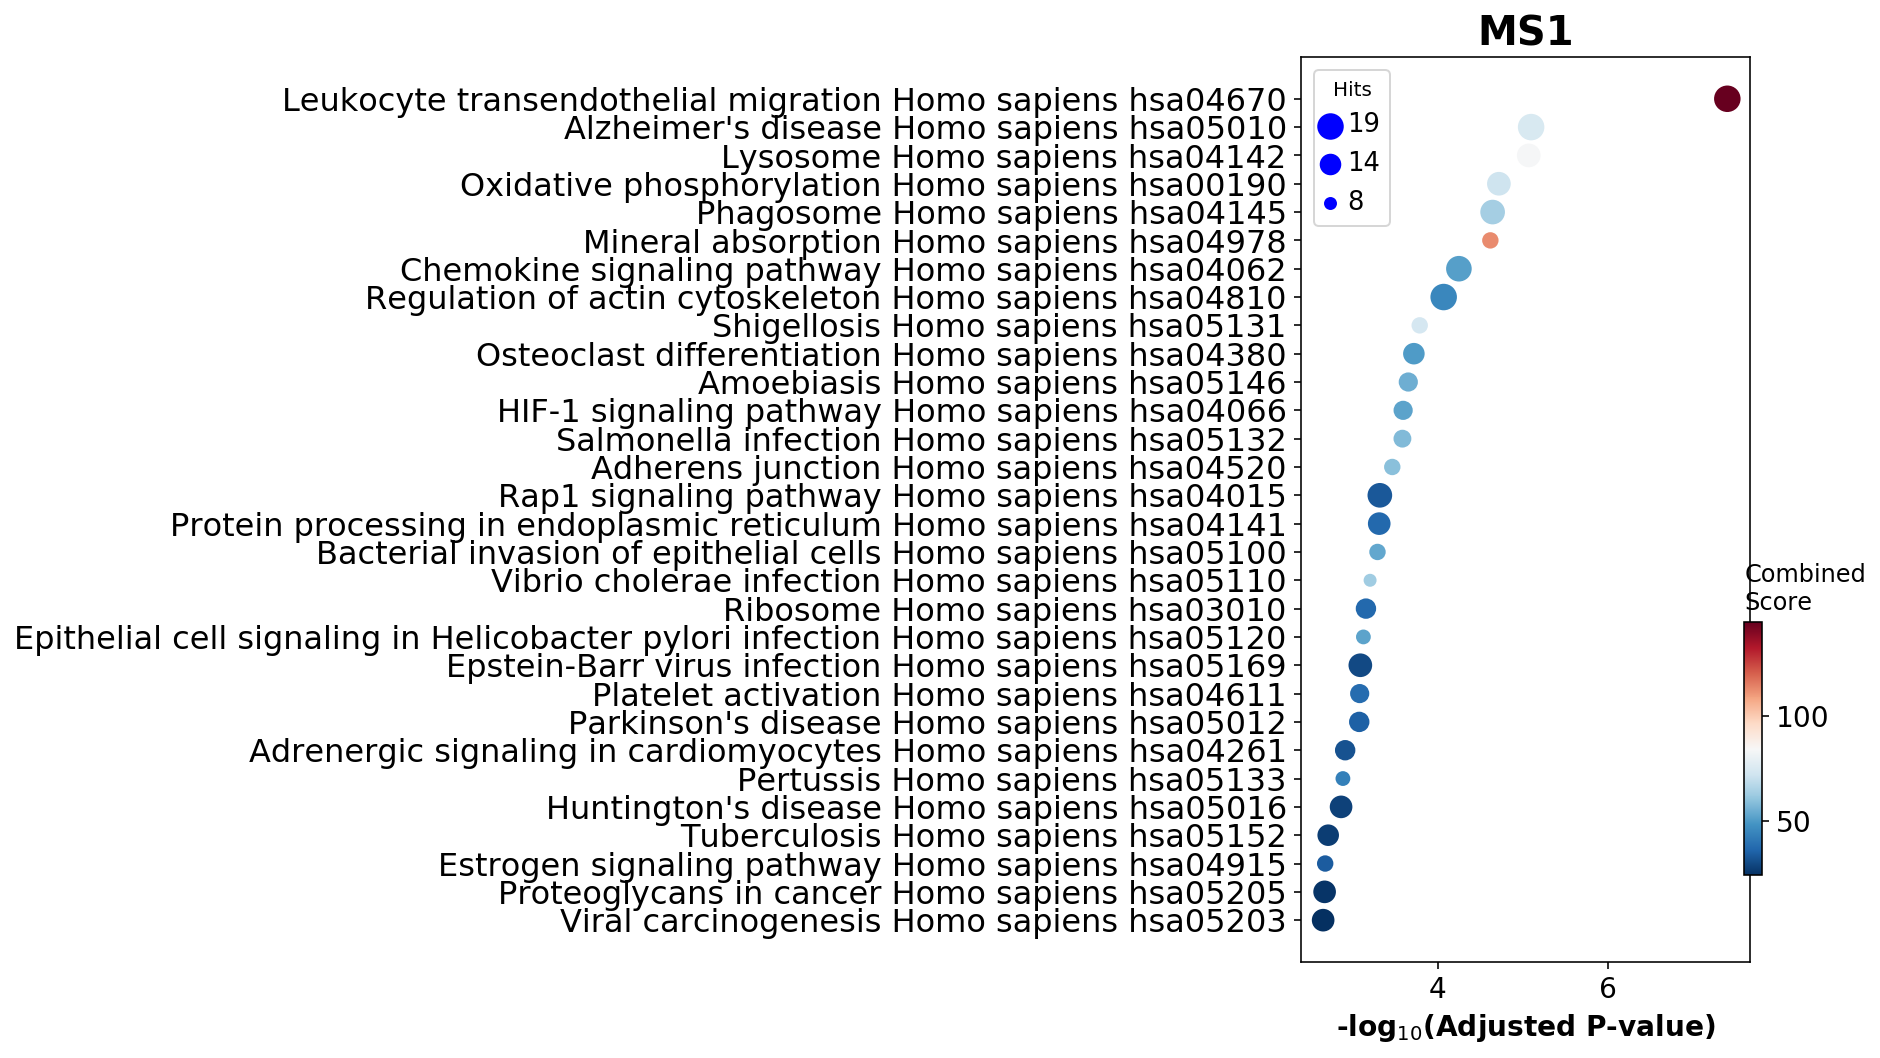

In [7]:
sc.tl.rank_genes_groups(adata, 'subclusters', groups=['MS1'], reference='MS2', n_genes=2000, 
                        use_raw=True, method = 'wilcoxon')
i=0
pval_cutoff = sum(pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).iloc[:,i] < 5e-2)
pval_cutoff = pval_cutoff if pval_cutoff < 2000 else 2000
print(pval_cutoff)
diff_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:pval_cutoff,i]

enr = gp.enrichr(gene_list=diff_genes[:1000],
                 gene_sets=['KEGG_2016'], cutoff=0.10)
gp.dotplot(enr.results, title='MS1', figsize=(4,8), cutoff=0.10, top_term=30)

### Plot MS1 flow-abundance and RNA-seq correlation

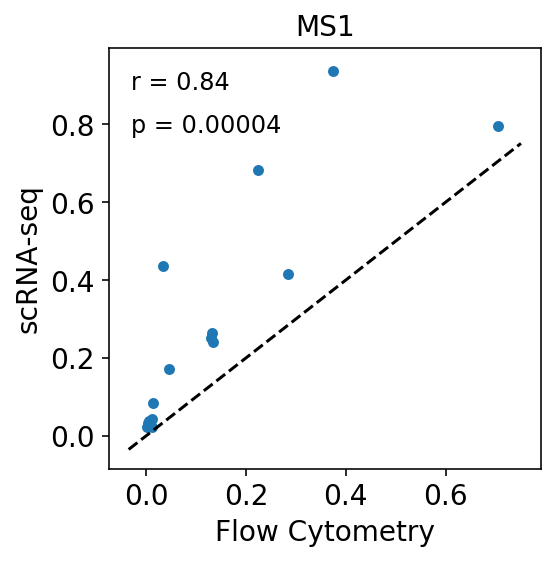

In [8]:
m1_abundance = pd.read_csv('./ms1_sort_table.csv', index_col=0)
m1_abundance = m1_abundance/100

anno_subsets = 'subclusters'
anno_pointdef = 'patient'

## Get number of categories
subset_ids = adata.obs[anno_subsets].cat.categories.tolist()
n_subsets = len(subset_ids)
patient_ids = adata.obs[anno_pointdef].unique()
n_patients = len(patient_ids)

## Calculate subset fractions
subset_frac = pd.DataFrame(np.empty([n_patients, n_subsets]),
                                index = patient_ids ,
                                columns = subset_ids)
for i in np.arange(n_patients):
    ind2 = adata.obs[anno_pointdef] == patient_ids[i]
    for j in np.arange(n_subsets):
        ind1 = adata.obs[anno_subsets] == subset_ids[j]
        subset_frac.iloc[i,j] = sum(ind1&ind2)
subset_frac = subset_frac.apply(lambda x: x/sum(x),axis=1)

m1_abundance['MS1 - scRNA-seq'] = subset_frac[['MS1']]
plt.figure(figsize=(4,4))
plt.scatter(m1_abundance['MS1'],m1_abundance['MS1 - scRNA-seq'], s=20)
plt.gca().plot([max(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]), 
                min(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])],
               [max(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]), 
                min(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1])],
               'k--')
plt.grid(None)
plt.xlabel('Flow Cytometry'), plt.ylabel('scRNA-seq')
pearson, p_val = sp.stats.pearsonr(m1_abundance['MS1'],m1_abundance['MS1 - scRNA-seq'])
plt.text(x=0.05, y=0.9, fontdict={'size':12},
         s= 'r = %.2f' % pearson, 
         transform=plt.gca().transAxes)
plt.text(x=0.05, y=0.8, fontdict={'size':12},
         s= 'p = %.5f' % p_val, 
         transform=plt.gca().transAxes)
plt.title('MS1')
plt.tight_layout()

### Project sorted MS1

In [9]:
adata_sort = sc.read('./matrix_MS1_sort.h5ad')
sc.pp.log1p(adata_sort)

adata = sc.read('./matrix_clustered.h5ad')
adata = adata[adata.obs['lineage']=='Mono']
adata.X = adata.raw.X

adata = adata.concatenate(adata_sort)
adata.raw = adata

In [10]:
sc.pp.filter_genes_dispersion(adata, subset=False)
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
adata.obsm['X_pca'] *= -1
sc.tl.tsne(adata, n_pcs=5)

extracting highly variable genes
    finished (0:00:01)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:13)
computing tSNE
    using 'X_pca' with n_pcs = 5
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:04:12)


Trying to set attribute `.obs` of view, making a copy.
... storing 'HTO' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'channel-HTO' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'channel_str' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cohort' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'leiden' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'lineage' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'patient' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'pheno' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sort' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'sort_gate' as categ

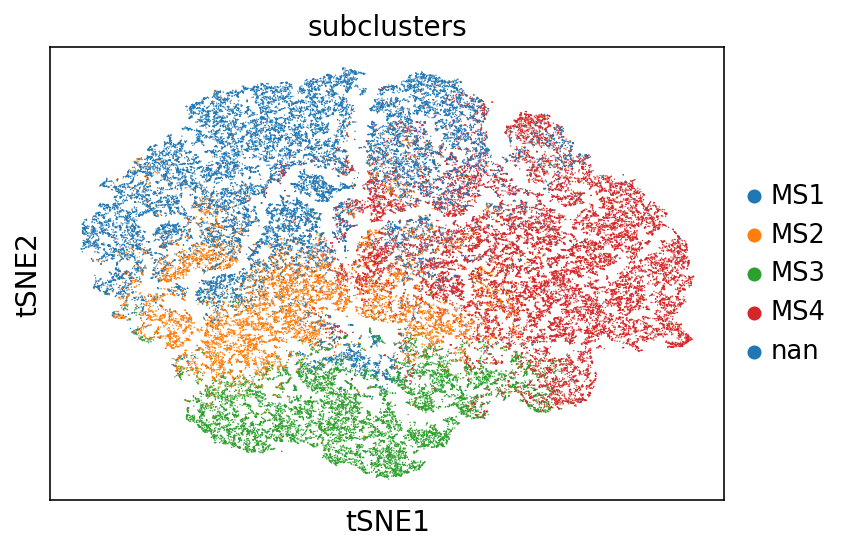

In [11]:
cmap = cm.get_cmap('tab10')
ax = sc.pl.tsne(adata[adata.obs['subclusters']!='nan'], color=['subclusters'],
                palette=[cmap(0),cmap(1),cmap(2),cmap(3)], show=True)

... storing 'HTO' as categorical
... storing 'channel-HTO' as categorical
... storing 'channel_str' as categorical
... storing 'cohort' as categorical
... storing 'day' as categorical
... storing 'leiden' as categorical
... storing 'lineage' as categorical
... storing 'patient' as categorical
... storing 'pheno' as categorical
... storing 'sort' as categorical
... storing 'sort_gate' as categorical
... storing 'subclusters' as categorical


computing density on 'tsne'
--> added
    'tsne_density_sort_gate', densities (adata.obs)
    'tsne_density_sort_gate_params', parameter (adata.uns)


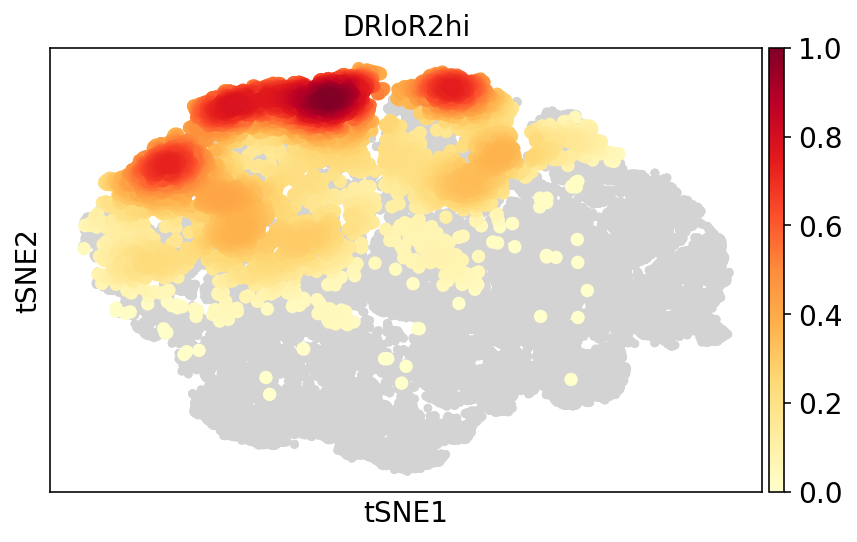

In [12]:
sc.tl.embedding_density(adata, basis='tsne', groupby='sort_gate')
sc.pl.embedding_density(adata, basis='tsne', key='tsne_density_sort_gate', group='DRloR2hi')

### Get MS1 cNMF results

In [13]:
adata = sc.read('./matrix_clustered.h5ad')
adata = adata[adata.obs['sort']=='CD45']
adata = adata[adata.obs['subclusters']=='MS1']

In [14]:
adata.X = adata.raw.X
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.tsne(adata, n_pcs=10)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:20)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:38)


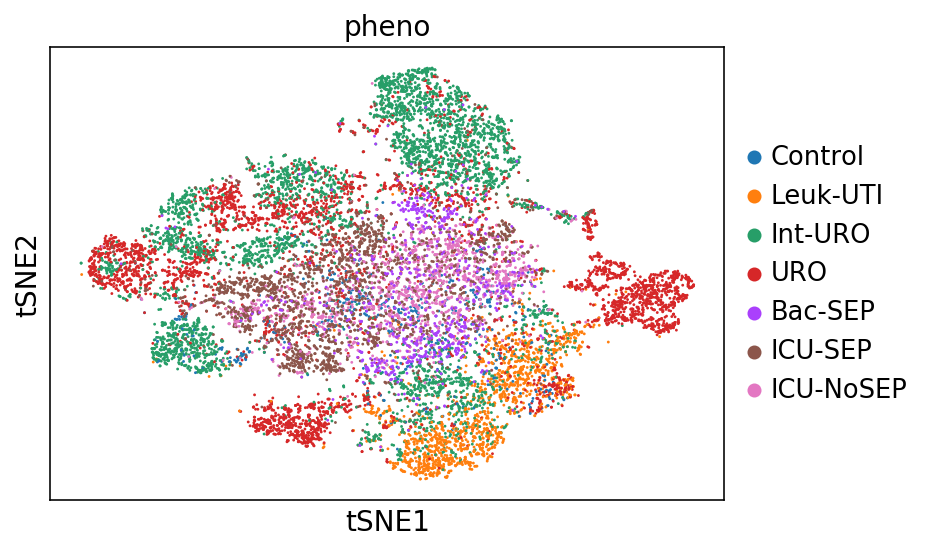

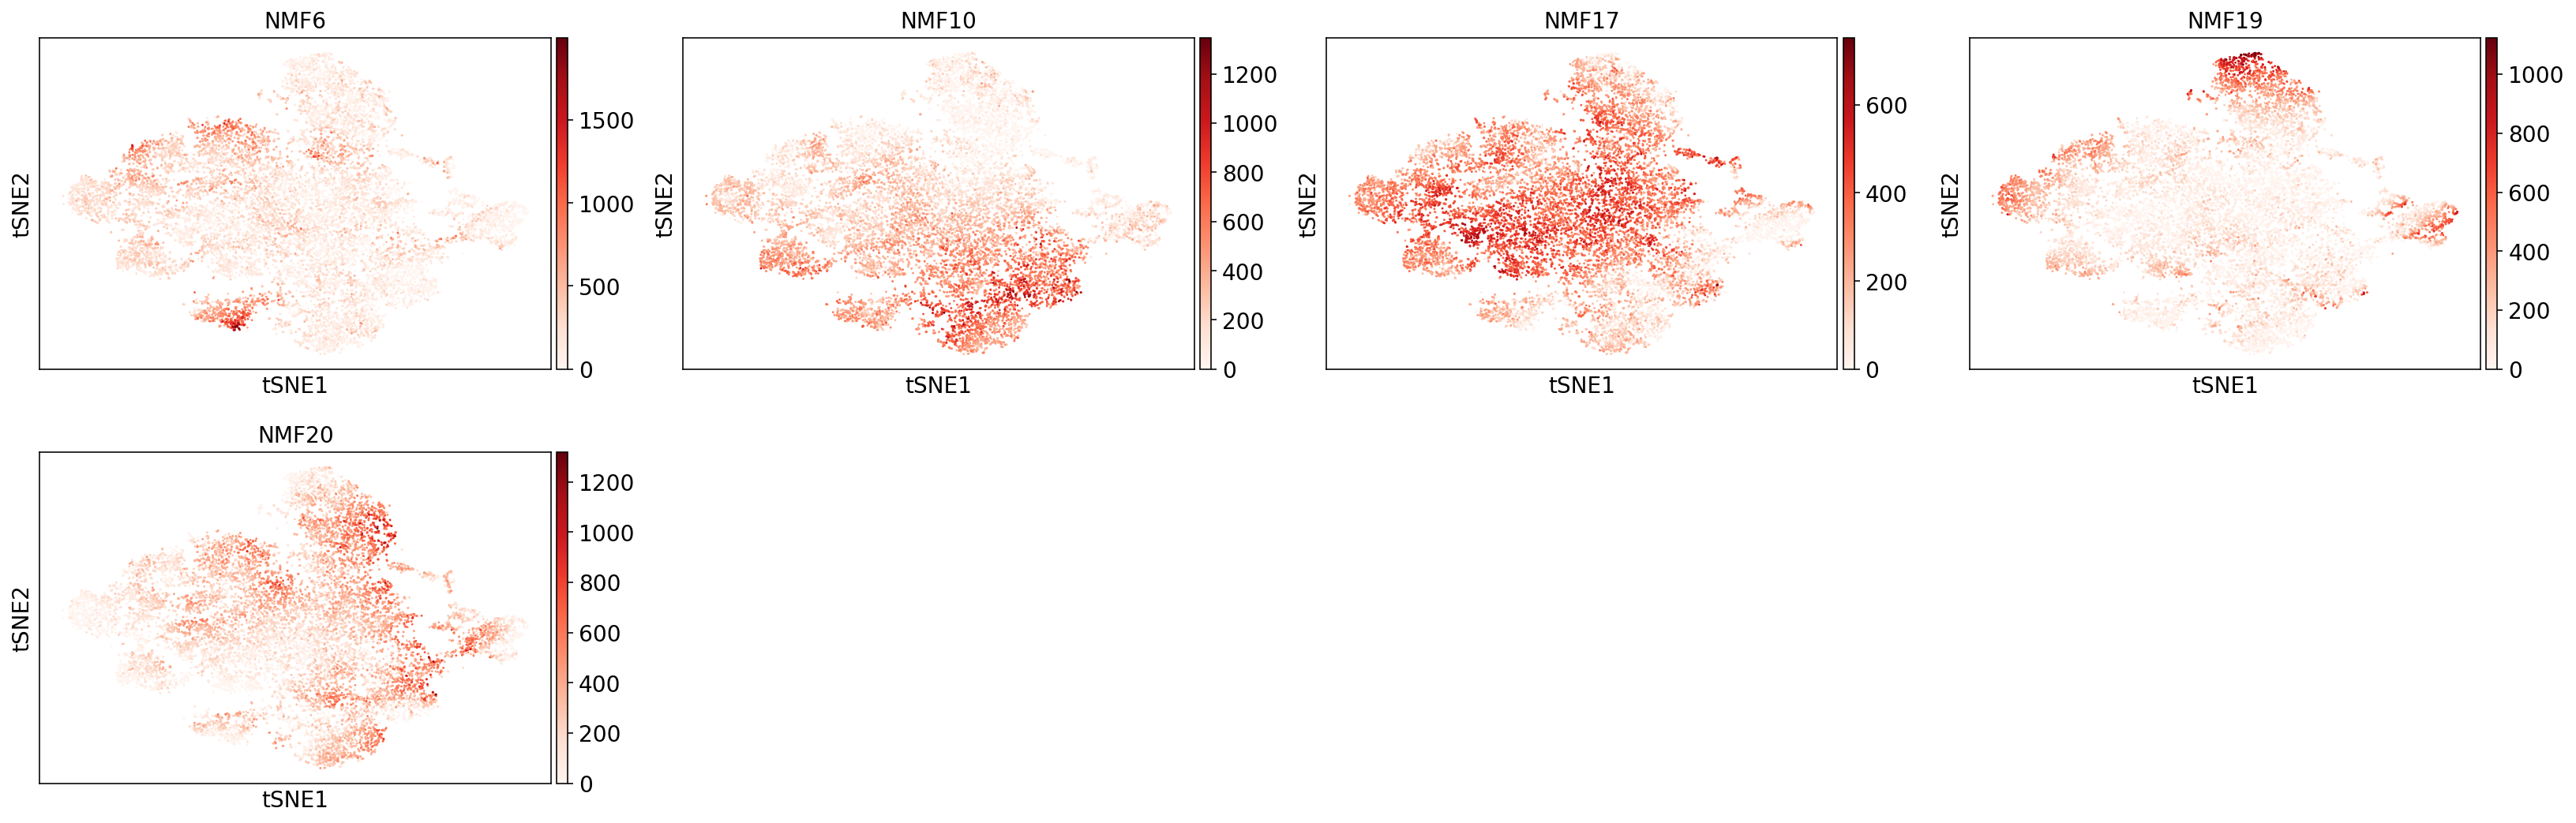

In [15]:
cell_usage = pd.read_csv('./ms1_cNMF_usage.txt', sep='\t', index_col=0)

for i in cell_usage.columns:
    adata.obs['NMF'+i] = cell_usage[i]
    
sc.pl.tsne(adata, color=['pheno'])
sc.pl.tsne(adata, color=['NMF6','NMF10','NMF17','NMF19','NMF20'], cmap='Reds')

### Get mean gene module usage and find correlation with SOFA scores

In [16]:
adata = adata[adata.obs['pheno'].isin(['Int-URO','URO','Bac-SEP','ICU-SEP','ICU-NoSEP'])]
nmf_patient_table = adata.obs.iloc[:,[8,9,10]]
nmf_patient_table[['NMF'+i for i in cell_usage]] = adata.obs.iloc[:,14:34]
nmf_patient_table = nmf_patient_table.groupby(['patient','day','pheno']).mean().dropna().reset_index()
nmf_patient_table.index = nmf_patient_table['patient']

In [17]:
clinical_data = pd.read_csv('./clinical_data.csv', index_col=0)
clinical_data = clinical_data[clinical_data['Day']==0]
nmf_patient_table['SOFA'] = clinical_data['SOFA']
nmf_patient_table = nmf_patient_table.dropna()

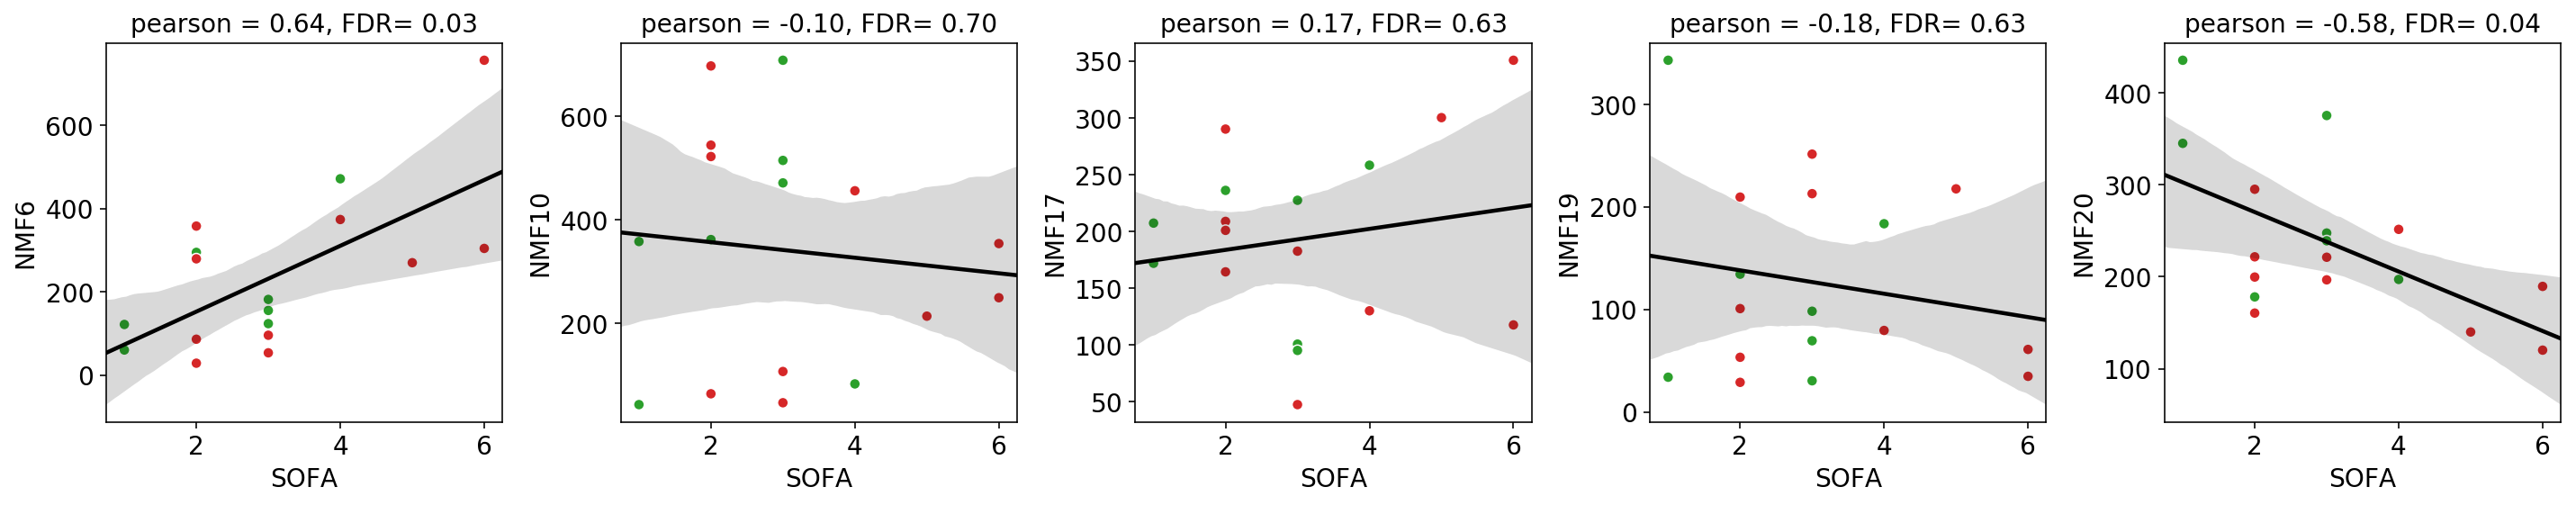

In [18]:
nmf_patient_table_mgh = nmf_patient_table[nmf_patient_table['pheno'].isin(['Int-URO','URO'])]
nmf_patient_table_mgh['pheno'] = nmf_patient_table_mgh['pheno'].cat.remove_unused_categories()
cmap = cm.get_cmap('tab10')

r = np.ones(5)
p = np.ones(5)

plt.figure(figsize=(20,4))
for i, NMF in enumerate(['NMF6','NMF10','NMF17','NMF19','NMF20']):
    plt.subplot(1,5,i+1)
    sns.scatterplot(x='SOFA',y=NMF, hue='pheno', data=nmf_patient_table_mgh,
                    legend=False, palette=[cmap(2),cmap(3)])
    sns.regplot(x='SOFA',y=NMF, data=nmf_patient_table_mgh, scatter=False, color='black')
    r[i],p[i] = stats.pearsonr(nmf_patient_table_mgh['SOFA'],nmf_patient_table_mgh[NMF])
    
_, p = fdrcorrection(p)
for i, NMF in enumerate(['NMF6','NMF10','NMF17','NMF19','NMF20']):
    plt.subplot(1,5,i+1)    
    plt.title('pearson = %.2f, FDR= %.2f' % (r[i],p[i]))
    plt.grid(False)
    
plt.tight_layout()

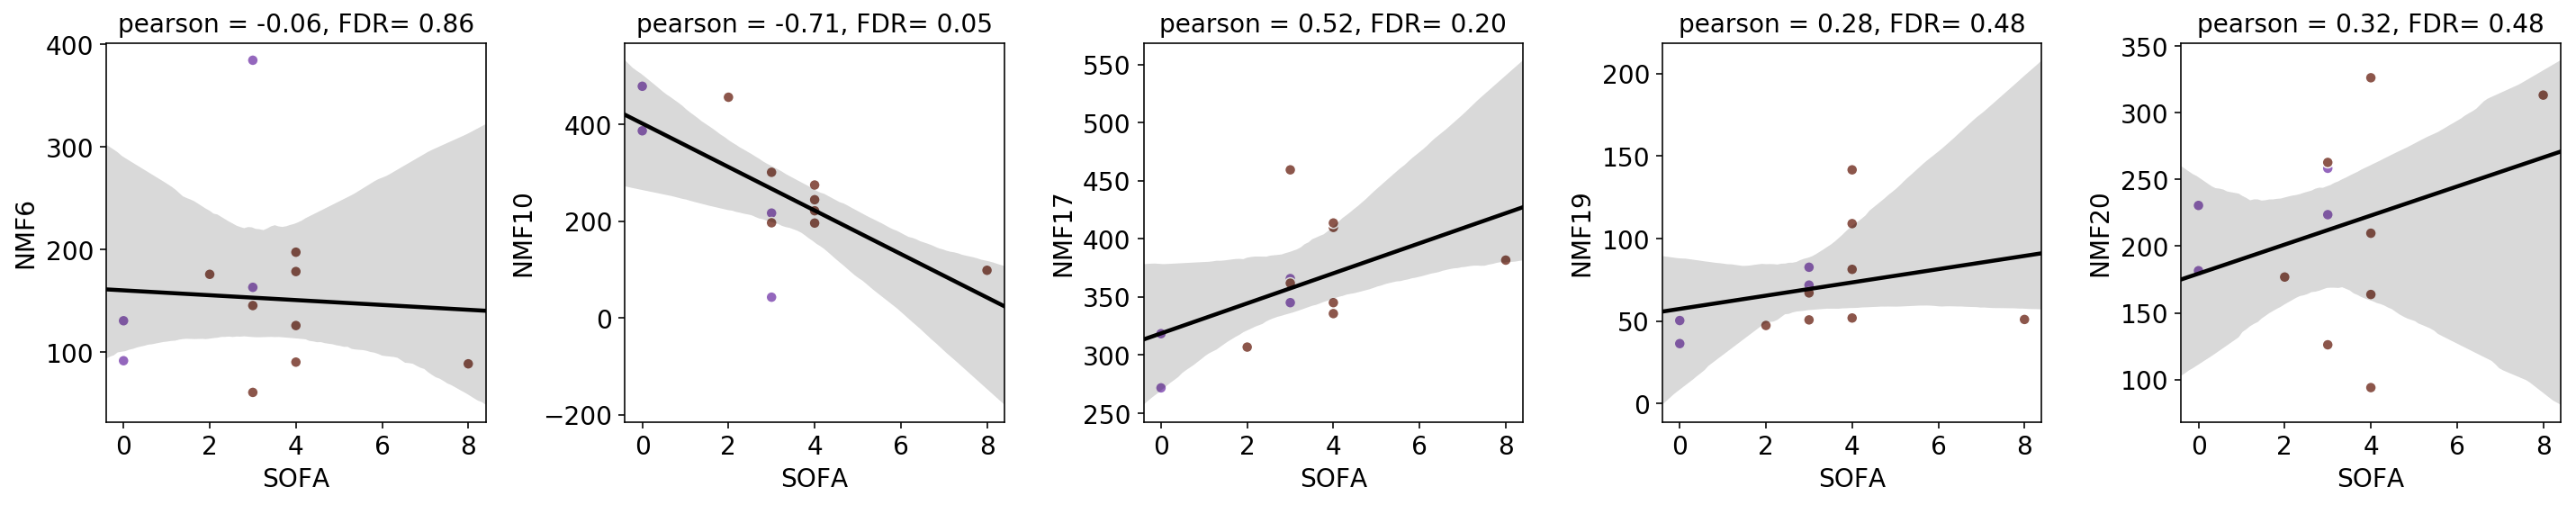

In [19]:
nmf_patient_table_bwh = nmf_patient_table[nmf_patient_table['pheno'].isin(['Bac-SEP','ICU-SEP'])]
nmf_patient_table_bwh['pheno'] = nmf_patient_table_bwh['pheno'].cat.remove_unused_categories()

cmap = cm.get_cmap('tab10')
r = np.ones(5)
p = np.ones(5)

plt.figure(figsize=(20,4))
for i, NMF in enumerate(['NMF6','NMF10','NMF17','NMF19','NMF20']):
    plt.subplot(1,5,i+1)
    sns.scatterplot(x='SOFA',y=NMF, hue='pheno', data=nmf_patient_table_bwh,
                    legend=False, palette=[cmap(4),cmap(5)])
    sns.regplot(x='SOFA',y=NMF, data=nmf_patient_table_bwh, scatter=False, color='black')
    r[i],p[i] = stats.pearsonr(nmf_patient_table_bwh['SOFA'],nmf_patient_table_bwh[NMF])
    plt.xticks([0,2,4,6,8])
    
_, p = fdrcorrection(p)
for i, NMF in enumerate(['NMF6','NMF10','NMF17','NMF19','NMF20']):
    plt.subplot(1,5,i+1)    
    plt.title('pearson = %.2f, FDR= %.2f' % (r[i],p[i]))
    plt.grid(False)
plt.tight_layout()